In [46]:
# 通过多项式拟合交互式探索模型选择、过拟合和欠拟合概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l  # 导入深度学习库d2l

In [47]:
# 生成模拟数据
# 使用三阶多项式生成训练和测试数据的标签: y = 5 + 1.2x - 3.4(x^2 / 2!) + 5.6(x^3 / 3!) + ε, 其中ε ~ N(0, 0.1^2)
max_degree = 20  # 多项式最大阶数
n_train, n_test = 100, 100  # 训练集和测试集大小

# 初始化真实权重（只有前4项非零）
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

# 生成特征和多项式特征
features = np.random.normal(size=(n_train + n_test, 1))  # 生成随机特征
np.random.shuffle(features)  # 打乱特征顺序

# 创建多项式特征矩阵：每列是特征的幂次方
# np.power(a, b) 对 a 和 b 中对应位置的元素分别进行幂运算，要求两数组形状相同（或可广播）
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

# 应用阶乘归一化 (x^k / k!)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n+1) = n!

# 计算标签并添加高斯噪声
labels = np.dot(poly_features, true_w)  # 点积
labels += np.random.normal(scale=0.1, size=labels.shape)  # 添加噪声

In [48]:
# 看一下前2个样本
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]  # 打印前两个样本

(tensor([[-0.6446],
         [ 0.7280]]),
 tensor([[ 1.0000e+00, -6.4460e-01,  2.0775e-01, -4.4639e-02,  7.1936e-03,
          -9.2740e-04,  9.9633e-05, -9.1748e-06,  7.3926e-07, -5.2947e-08,
           3.4130e-09, -2.0000e-10,  1.0743e-11, -5.3270e-13,  2.4527e-14,
          -1.0540e-15,  4.2463e-17, -1.6101e-18,  5.7659e-20, -1.9562e-21],
         [ 1.0000e+00,  7.2805e-01,  2.6502e-01,  6.4317e-02,  1.1706e-02,
           1.7046e-03,  2.0683e-04,  2.1512e-05,  1.9577e-06,  1.5837e-07,
           1.1530e-08,  7.6311e-10,  4.6298e-11,  2.5929e-12,  1.3484e-13,
           6.5445e-15,  2.9779e-16,  1.2753e-17,  5.1583e-19,  1.9766e-20]]),
 tensor([3.4658, 5.6252]))

In [49]:
# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """ 评估给定数据集上模型的损失 """
    metric = d2l.Accumulator(2)  # 创建累加器：[总损失, 样本数]
    for X, y in data_iter:
        out = net(X)  # 前向传播
        y = y.reshape(out.shape)  # 调整标签形状匹配输出
        l = loss(out, y)  # 计算损失
        metric.add(l.sum(), l.numel())  # 累加损失和样本数
    return metric[0] / metric[1]  # 返回平均损失

In [50]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()  # 使用均方误差损失
    input_shape = train_features.shape[-1]  # 输入特征维度

    # 创建简单线性模型（无偏置项）
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    batch_size = min(10, train_labels.shape[0])  # 小批量大小
    # 创建训练和测试数据迭代器
    train_iter = d2l.load_array(
        (train_features, train_labels.reshape(-1, 1)), 
        batch_size
    )
    test_iter = d2l.load_array(
        (test_features, test_labels.reshape(-1, 1)), 
        batch_size, 
        is_train=False
    )
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)  # 随机梯度下降优化器

    # 创建动画绘制器（对数坐标）
    animator = d2l.Animator(
        xlabel='epoch', 
        ylabel='loss', 
        yscale='log', 
        xlim=[1, num_epochs], 
        ylim=[1e-3, 1e2], 
        legend=['train', 'test']
    )

    # 训练循环
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)  # 训练一个epoch

        # 每20个epoch记录一次损失
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(
                epoch + 1, 
                (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss))
            )
            
    print('weight:', net[0].weight.data.numpy())  # 打印学习到的权重

weight: [[ 5.0032215  1.279923  -3.3951018  5.4280577]]


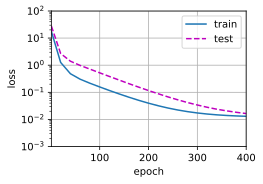

In [51]:
# 三阶多项式函数拟合(正态)
# 使用前4个特征（对应1, x, x^2/2!, x^3/3!）
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
     labels[:n_train], labels[n_train:])

weight: [[3.5469625 3.6022363]]


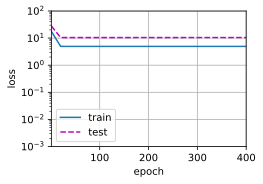

In [52]:
# 线性函数拟合(欠拟合)
# 只使用前2个特征（1, x）
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

weight: [[ 5.0030117   1.26899    -3.3729115   5.258483   -0.18129623  1.175381
   0.20479332  0.12303344 -0.0292479  -0.1769227   0.20975858 -0.14055079
   0.21480303 -0.03937623  0.08736041  0.07205328  0.22345424 -0.15579438
  -0.19460341 -0.07417066]]


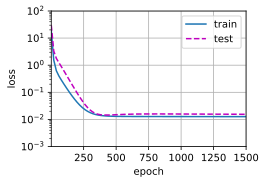

In [53]:
# 高阶多项式函数拟合(过拟合)
# 使用所有20个多项式特征
train(poly_features[:n_train, :], poly_features[n_train:, :],
     labels[:n_train], labels[n_train:], num_epochs=1500)